# Market Satış Fiyatı Tahmin - YZTA Datathon

# 1. Giriş
## 1.1 Projenin Amacı
Proje amacı Bu yarışmada amacımız her ürünün satış fiyatını tahmin etmektir. Test setindeki her id için ürün fiyatı değişkeninin değerini tahmin etmeniz gerekir.

## 1.2 Veri Seti ve Veri Setine İlk Bakış
- ``tarih`` - Ürünün özelliklerinin belirlendiği tarih
- ``ürün`` - Ürünün ismi
- ``ürün besin değeri`` - Ürünün sahip olduğu besin değeri
- ``ürün kategorisi`` - Ürünün ait olduğu kategori
- ``ürün fiyatı`` - Ürünün fiyatı
- ``ürün üretim yeri`` - Ürünün üretim yeri
- ``market``- Ürünün satıldığı market
- ``şehir`` - Ürünün satıldığı şehir
sütunlarına sahiptir.

Hedef değişkenimiz ürün fiyatıdır. ön düşünce olarak ürünün fiyatına etki eden unsurlar, ürün kategorisi, ürünün besin değeri olabilir. market ve şehir bazında minimal etkiler olabileceğini düşünüyoruz.

## 1.3 Kullanılan Kütüphaneler
- pandas
- numpy
- matplotlib
- seaborn
- statsmodels - SARIMAX

In [18]:
# Gerekli kütüphaneleri içe aktaralım
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Görselleştirme stilini ayarlayalım
plt.style.use('seaborn-v0_8') 
sns.set_palette("deep")

In [19]:
# Verileri yükleyelim
train_data = pd.read_csv("./datasets/train_data.csv")
test_data = pd.read_csv("./datasets/test_data.csv")

In [20]:
# Tarih sütunlarını datetime formatına çevirelim
train_data['tarih'] = pd.to_datetime(train_data['tarih'])
test_data['tarih'] = pd.to_datetime(test_data['tarih'])

In [21]:
# Eğitim verisinin ilk birkaç satırını görelim
train_data.head(10)

,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün fiyatı,ürün üretim yeri,market,şehir
0,2019-01-01,kıyma,120,et,32.70,Yurt içi,K,S
1,2019-01-01,tavuk,103,et,11.04,Yurt içi,K,S
2,2019-01-01,hindi,160,et,11.20,Yurt içi,K,S
3,2019-01-01,Bakla-kuru,354,sebze ve bakliyat,7.04,Yurt içi,K,S
4,2019-01-01,Bakla-taze,72,sebze ve bakliyat,13.28,Yurt içi,K,S
5,2019-01-01,Bamya,42,sebze ve bakliyat,5.05,Yurt içi,K,S
6,2019-01-01,Barbunya-kuru,346,sebze ve bakliyat,6.09,Yurt içi,K,S
7,2019-01-01,Bezelye-taze,47,sebze ve bakliyat,11.96,Yurt içi,K,S
8,2019-01-01,Biber-yeşil,25,sebze ve bakliyat,12.10,Yurt içi,K,S
9,2019-01-01,Brüksel laha.,47,sebze ve bakliyat,22.93,Yurt içi,K,S


# Keşifsel Veri Analizi - EDA

Bu bölümde, veri setimizi daha iyi anlamak için çeşitli analizler ve görselleştirmeler yaptık. Bu analizler, veri setinin yapısını, değişkenler arasındaki ilişkileri ve zaman içindeki trendleri anlamamıza yardımcı olacaktır.


In [22]:
# Veri seti hakkında temel bilgiler
print("Veri Seti Boyutu:", train_data.shape)
print("\nVeri Tipleri:")
print(train_data.dtypes)

Veri Seti Boyutu: (227520, 8)

Veri Tipleri:
tarih                datetime64[ns]
ürün                         object
ürün besin değeri             int64
ürün kategorisi              object
ürün fiyatı                 float64
ürün üretim yeri             object
market                       object
şehir                        object
dtype: object


In [23]:
# Eksik değerleri kontrol edelim
print("\nEksik Değerler:")
print(train_data.isnull().sum())


Eksik Değerler:
tarih                0
ürün                 0
ürün besin değeri    0
ürün kategorisi      0
ürün fiyatı          0
ürün üretim yeri     0
market               0
şehir                0
dtype: int64


In [24]:
# Özet istatistikler
print("\nÖzet İstatistikler:")
print(train_data.describe())


Özet İstatistikler:
       ürün besin değeri    ürün fiyatı
count      227520.000000  227520.000000
mean          143.113924      17.018837
std           133.218871      14.470524
min             8.000000       0.740000
25%            41.000000       7.380000
50%            83.000000      12.860000
75%           250.000000      21.630000
max           402.000000     164.530000


In [25]:
# Kategorik sütunlardaki benzersiz değerler
print("\nBenzersiz Ürün Kategorileri:", train_data['ürün kategorisi'].nunique())
print("Benzersiz Ürünler:", train_data['ürün'].nunique())
print("Benzersiz Marketler:", train_data['market'].nunique())
print("Benzersiz Şehirler:", train_data['şehir'].nunique())


Benzersiz Ürün Kategorileri: 6
Benzersiz Ürünler: 79
Benzersiz Marketler: 3
Benzersiz Şehirler: 8


## Ürün Kategorilerinin Dağılımı

Aşağıdaki grafik, veri setimizdeki ürün kategorilerinin dağılımını göstermektedir. Bu dağılım, hangi kategorilerin daha fazla temsil edildiğini anlamamıza yardımcı olacaktır.


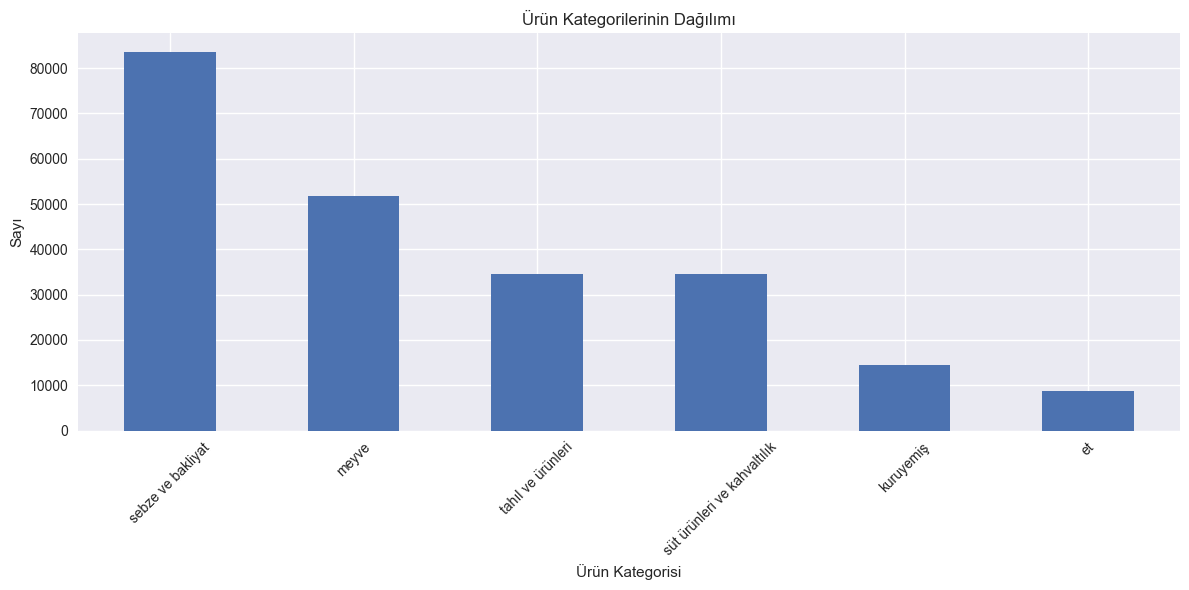

In [26]:
# Ürün kategorilerinin dağılımı
plt.figure(figsize=(12, 6))
train_data['ürün kategorisi'].value_counts().plot(kind='bar')
plt.title('Ürün Kategorilerinin Dağılımı')
plt.xlabel('Ürün Kategorisi')
plt.ylabel('Sayı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Kategorilere Göre Fiyat Değişimi

Aşağıdaki grafik, farklı ürün kategorilerinin zaman içindeki ortalama fiyat değişimlerini göstermektedir. Bu, hangi kategorilerin daha hızlı fiyat artışına sahip olduğunu anlamamıza yardımcı olacaktır.

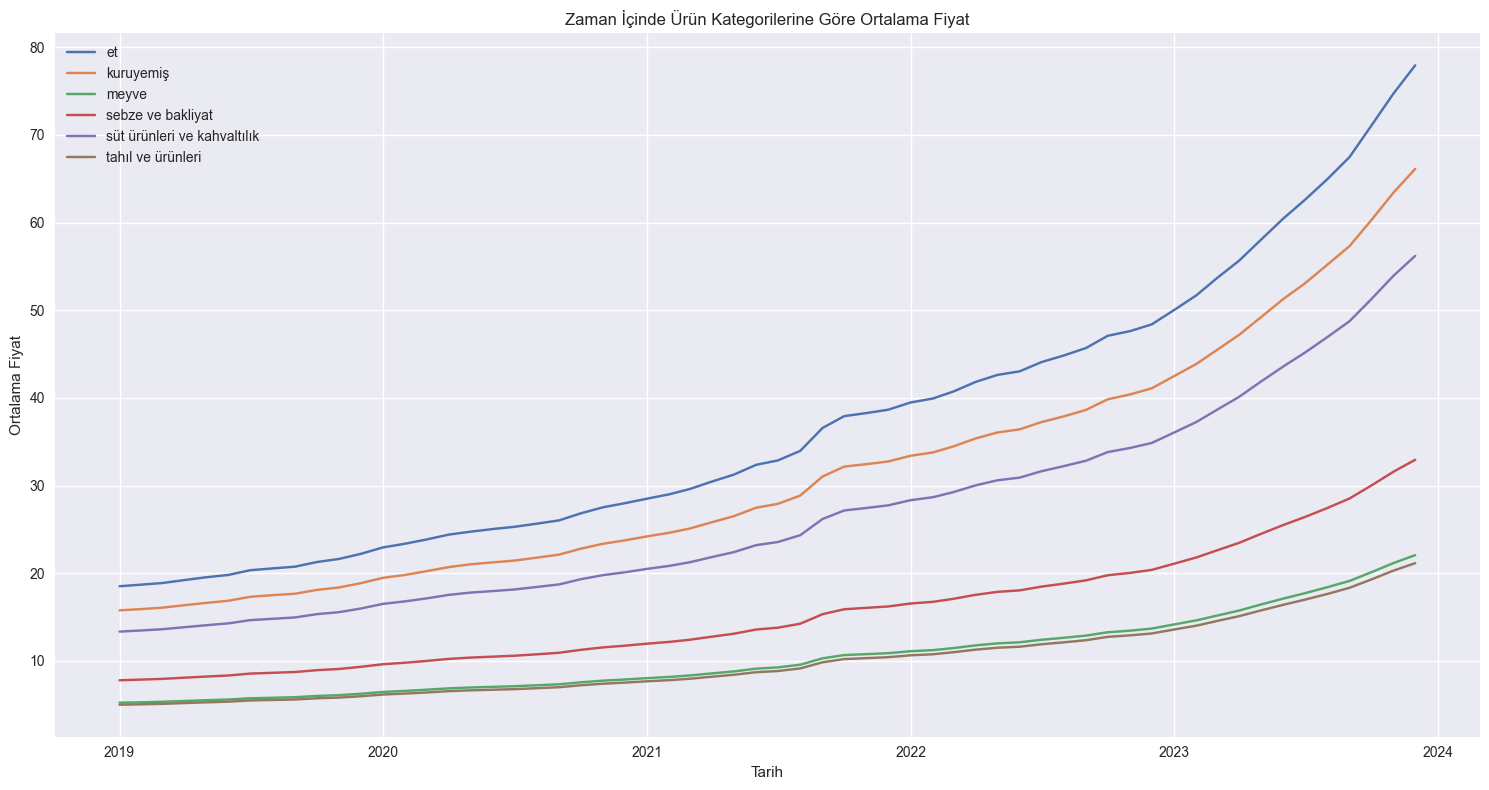

In [27]:
# Farklı ürün kategorileri için fiyatların zaman serisi
plt.figure(figsize=(15, 8))

# Tarihe ve ürün kategorisine göre gruplandırarak ortalama fiyatı hesaplama
kategori_zaman_serisi = train_data.groupby(['tarih', 'ürün kategorisi'])['ürün fiyatı'].mean().reset_index()

# Her kategori için zaman serisi çizimi
for kategori in kategori_zaman_serisi['ürün kategorisi'].unique():
    kategori_verisi = kategori_zaman_serisi[kategori_zaman_serisi['ürün kategorisi'] == kategori]
    plt.plot(kategori_verisi['tarih'], kategori_verisi['ürün fiyatı'], label=kategori)

plt.title('Zaman İçinde Ürün Kategorilerine Göre Ortalama Fiyat')
plt.xlabel('Tarih')
plt.ylabel('Ortalama Fiyat')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Fiyat Dağılımı

Aşağıdaki histogram, ürün fiyatlarının dağılımını göstermektedir. Bu grafik, fiyatların nasıl dağıldığını ve olası aykırı değerleri anlamamıza yardımcı olacaktır.

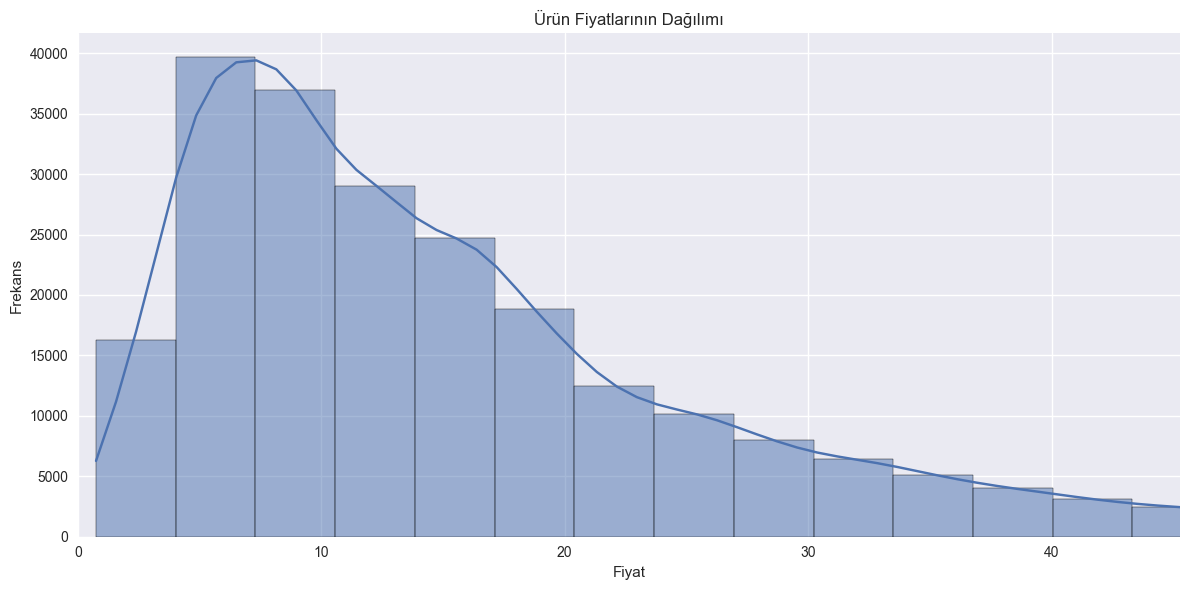

Çarpıklık: 2.346640643103203
Basıklık: 8.805061468546478


In [28]:
# Fiyat dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(train_data['ürün fiyatı'], kde=True, bins=50)
plt.title('Ürün Fiyatlarının Dağılımı')
plt.xlabel('Fiyat')
plt.ylabel('Frekans')
plt.xlim(0, train_data['ürün fiyatı'].quantile(0.95))  # Daha iyi görselleştirme için x eksenini 95. yüzdelikle sınırlama
plt.tight_layout()
plt.show()

# Çarpıklık ve basıklık hesaplama
skewness = train_data['ürün fiyatı'].skew()
kurtosis = train_data['ürün fiyatı'].kurt()
print(f"Çarpıklık: {skewness}")
print(f"Basıklık: {kurtosis}")

## Aykırı Değer Analizi

Veri setindeki olası aykırı değerleri tespit etmek için kutu grafiği ve IQR (Çeyrekler Arası Aralık) yöntemini kullandık. Ancak, bu analizde tespit edilen "aykırı" değerlerin aslında veri setinin doğal bir parçası olduğunu ve modelin eğitiminde bu değerlerin çıkarılmasının tahmin performansını olumsuz etkilediğini gözlemledik. Bu sebeple modelin eğitilmesinde aykırı değerler çıkarılmadı veya logaritmik dönüşüm uygulanmadı.

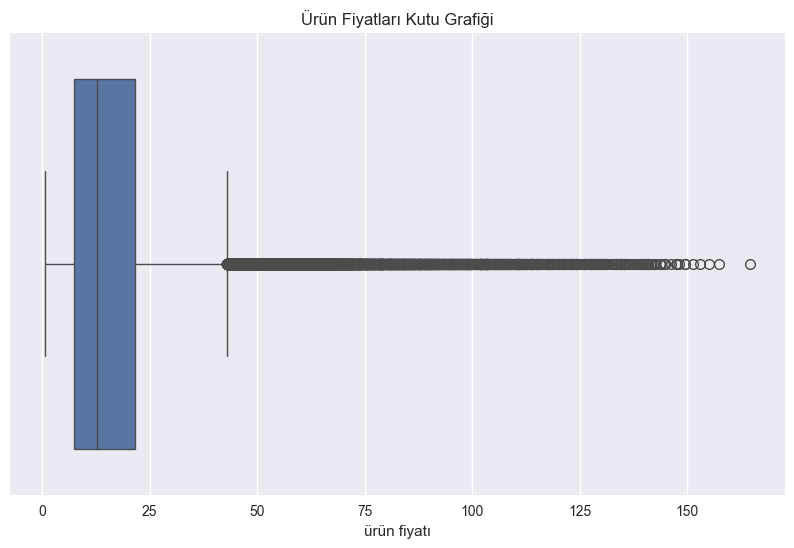

Aykırı değer sayısı: 13184
Aykırı değer yüzdesi: 5.79%


,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün fiyatı,ürün üretim yeri,market,şehir
39974,2019-11-01,kıyma,120,et,43.48,Yurt içi,C,L
43766,2019-12-01,kıyma,120,et,44.83,Yurt içi,C,L
46057,2020-01-01,kıyma,120,et,43.67,Yurt dışı,K,E
47005,2020-01-01,kıyma,120,et,44.25,Yurt dışı,K,A
47558,2020-01-01,kıyma,120,et,46.08,Yurt içi,C,L


In [29]:
# Fiyat aralığı ve aykırı değerler
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_data['ürün fiyatı'])
plt.title('Ürün Fiyatları Kutu Grafiği')
plt.show()

# Aykırı değerlerin tespiti
Q1 = train_data['ürün fiyatı'].quantile(0.25)
Q3 = train_data['ürün fiyatı'].quantile(0.75)
IQR = Q3 - Q1
alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR
aykiri_degerler = train_data[(train_data['ürün fiyatı'] < alt_sinir) | (train_data['ürün fiyatı'] > ust_sinir)]
print(f"Aykırı değer sayısı: {len(aykiri_degerler)}")
print(f"Aykırı değer yüzdesi: {(len(aykiri_degerler) / len(train_data)) * 100:.2f}%")

# Aykırı değerlerin incelenmesi
aykiri_degerler.head()

### Aykırı Değerler Hakkında Not

IQR yöntemi ile tespit edilen aykırı değerler, istatistiksel olarak veri setinin genel dağılımından sapma göstermektedir. Ancak, bu değerlerin detaylı incelenmesi sonucunda, bunların gerçekten hatalı veriler olmadığı, aksine bazı ürün kategorilerinin doğal fiyat aralığını yansıttığı görülmüştür.

Örneğin, lüks gıda ürünlerinin fiyatları doğal olarak daha yüksek olabilmektedir. Bu "aykırı" değerlerin modelden çıkarılması, özellikle bu tür ürünler için daha düşük fiyat tahminlerine yol açmakta ve modelin genel performansını olumsuz etkilemektedir.

Bu nedenle, bu projede aykırı değerleri filtrelemek yerine, tüm veri setini olduğu gibi kullanmayı tercih ettik. Bu yaklaşım, farklı fiyat segmentlerindeki ürünler için daha doğru tahminler yapılmasını sağlamaktadır.

## Ürün Kategorilerine Göre Fiyat Dağılımı

Aşağıdaki kutu grafiği, farklı ürün kategorilerindeki fiyat dağılımlarını göstermektedir. Bu, hangi kategorilerin daha yüksek veya daha değişken fiyatlara sahip olduğunu anlamamıza yardımcı olacaktır.

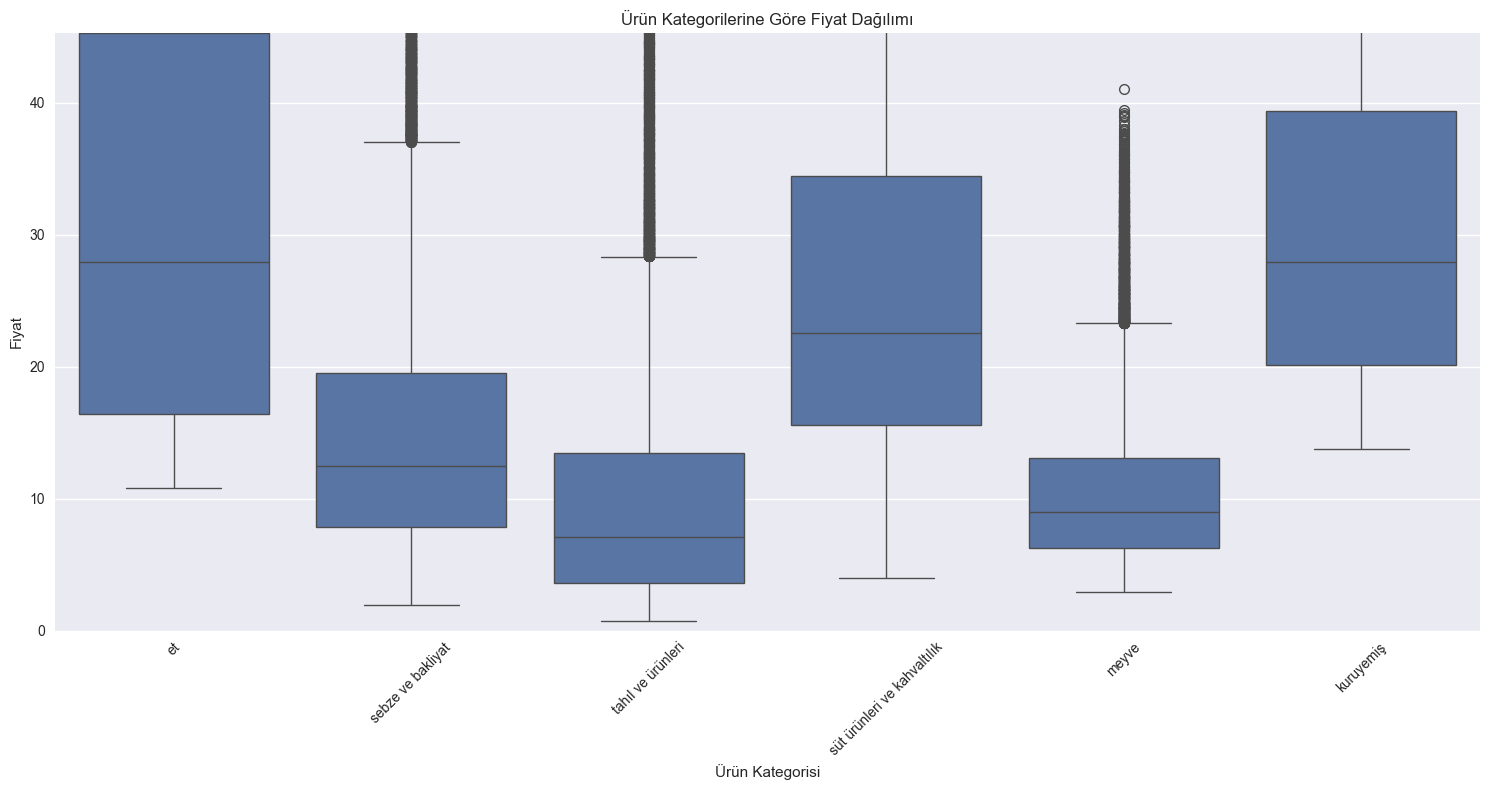

In [30]:
# Ürün kategorilerine göre fiyat dağılımı kutu grafiği
plt.figure(figsize=(15, 8))
sns.boxplot(x='ürün kategorisi', y='ürün fiyatı', data=train_data)
plt.title('Ürün Kategorilerine Göre Fiyat Dağılımı')
plt.xlabel('Ürün Kategorisi')
plt.ylabel('Fiyat')
plt.xticks(rotation=45)
plt.ylim(0, train_data['ürün fiyatı'].quantile(0.95))  # Daha iyi görselleştirme için y eksenini sınırlama
plt.tight_layout()
plt.show()

## Besin Değeri ve Fiyat İlişkisi

Aşağıdaki saçılım grafiği, ürünlerin besin değeri ile fiyatları arasındaki ilişkiyi göstermektedir. Bu, besin değeri yüksek ürünlerin daha pahalı olup olmadığını anlamamıza yardımcı olacaktır.

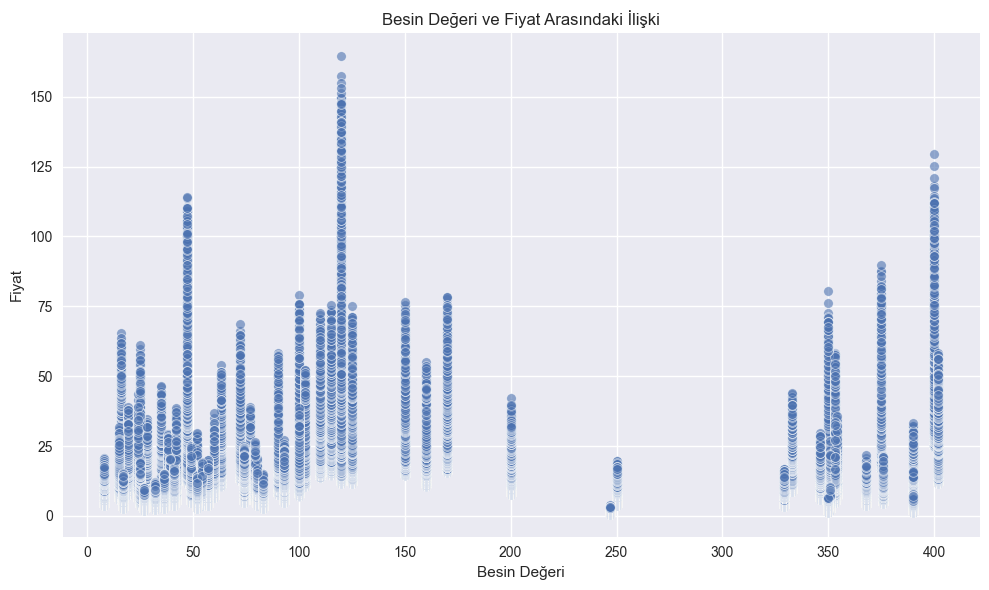

Besin Değeri ve Fiyat Arasındaki Korelasyon: 0.0161


In [31]:
# Ürün besin değeri ve fiyat arasındaki ilişki
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ürün besin değeri', y='ürün fiyatı', data=train_data, alpha=0.6)
plt.title('Besin Değeri ve Fiyat Arasındaki İlişki')
plt.xlabel('Besin Değeri')
plt.ylabel('Fiyat')
plt.grid(True)
plt.tight_layout()
plt.show()

# Korelasyon hesaplama
korelasyon = train_data['ürün besin değeri'].corr(train_data['ürün fiyatı'])
print(f"Besin Değeri ve Fiyat Arasındaki Korelasyon: {korelasyon:.4f}")

## Yerli ve İthal Ürünlerin Fiyat Karşılaştırması

Aşağıdaki kutu grafiği, yerli ve ithal ürünlerin fiyat dağılımlarını karşılaştırmaktadır. Bu, ithal ürünlerin yerli ürünlere göre daha pahalı olup olmadığını anlamamıza yardımcı olacaktır.

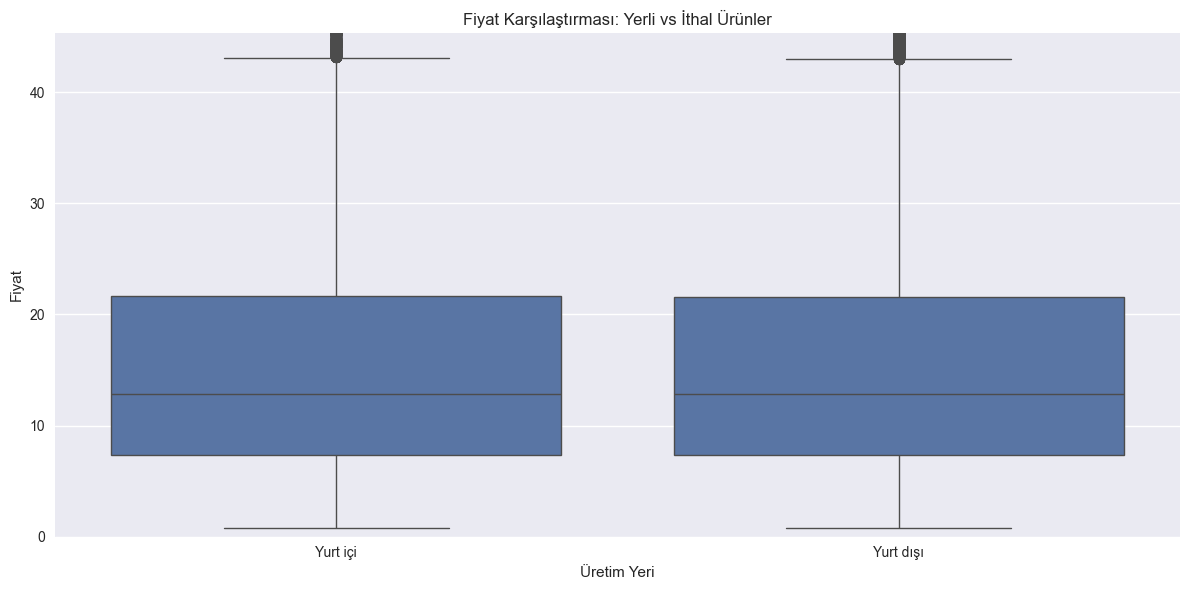

In [32]:
# Yerli ve ithal ürünlerin fiyat karşılaştırması
plt.figure(figsize=(12, 6))
sns.boxplot(x='ürün üretim yeri', y='ürün fiyatı', data=train_data)
plt.title('Fiyat Karşılaştırması: Yerli vs İthal Ürünler')
plt.xlabel('Üretim Yeri')
plt.ylabel('Fiyat')
plt.ylim(0, train_data['ürün fiyatı'].quantile(0.95))  # Daha iyi görselleştirme için y eksenini sınırlama
plt.tight_layout()
plt.show()

## Zaman İçinde Fiyat Trendi ve Aylık Enflasyon

Aşağıdaki grafikler, ortalama fiyatların zaman içindeki trendini ve aylık enflasyon oranlarını göstermektedir. Bu, fiyatların nasıl değiştiğini ve enflasyon dinamiklerini anlamamıza yardımcı olacaktır.

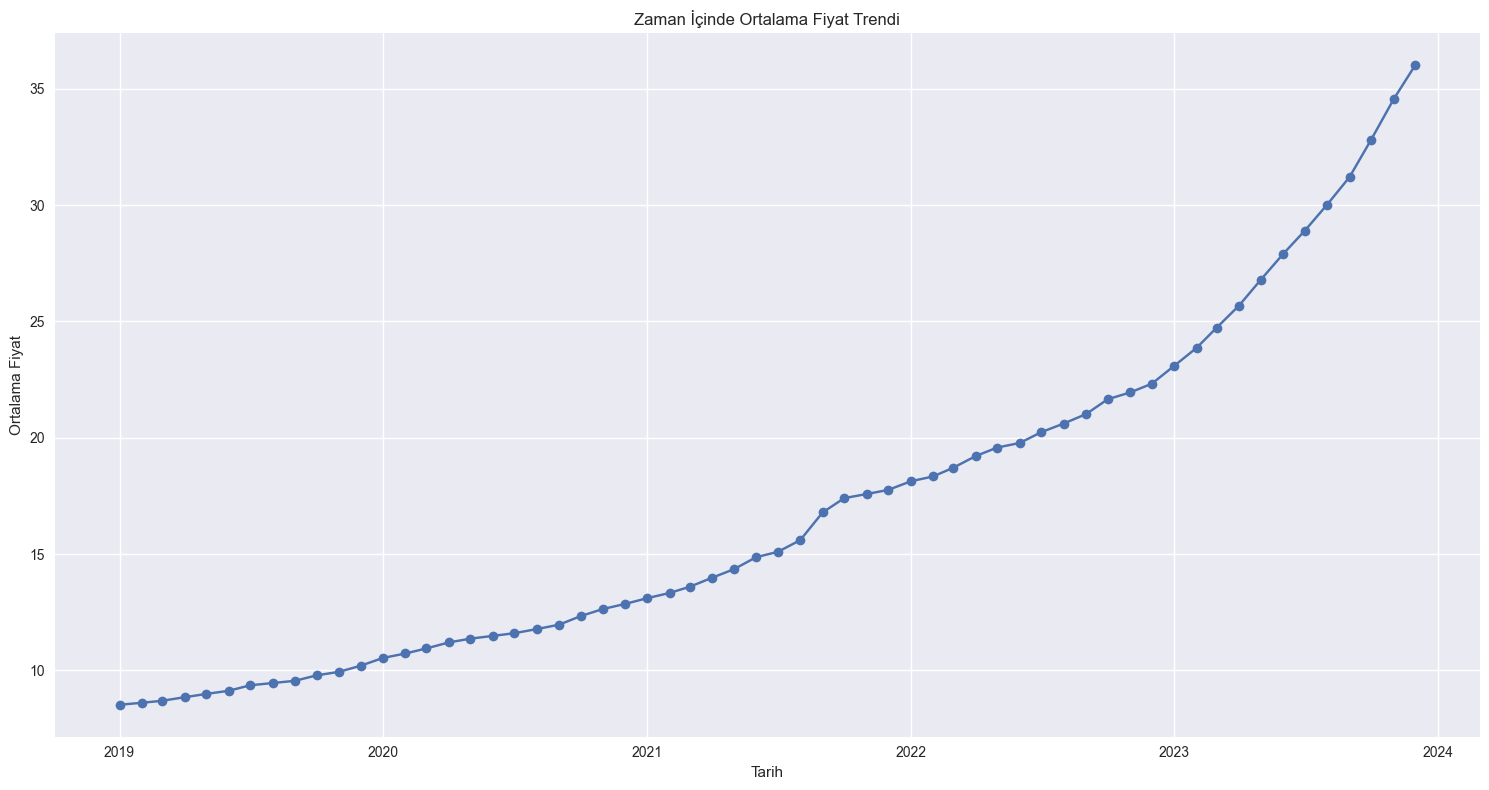

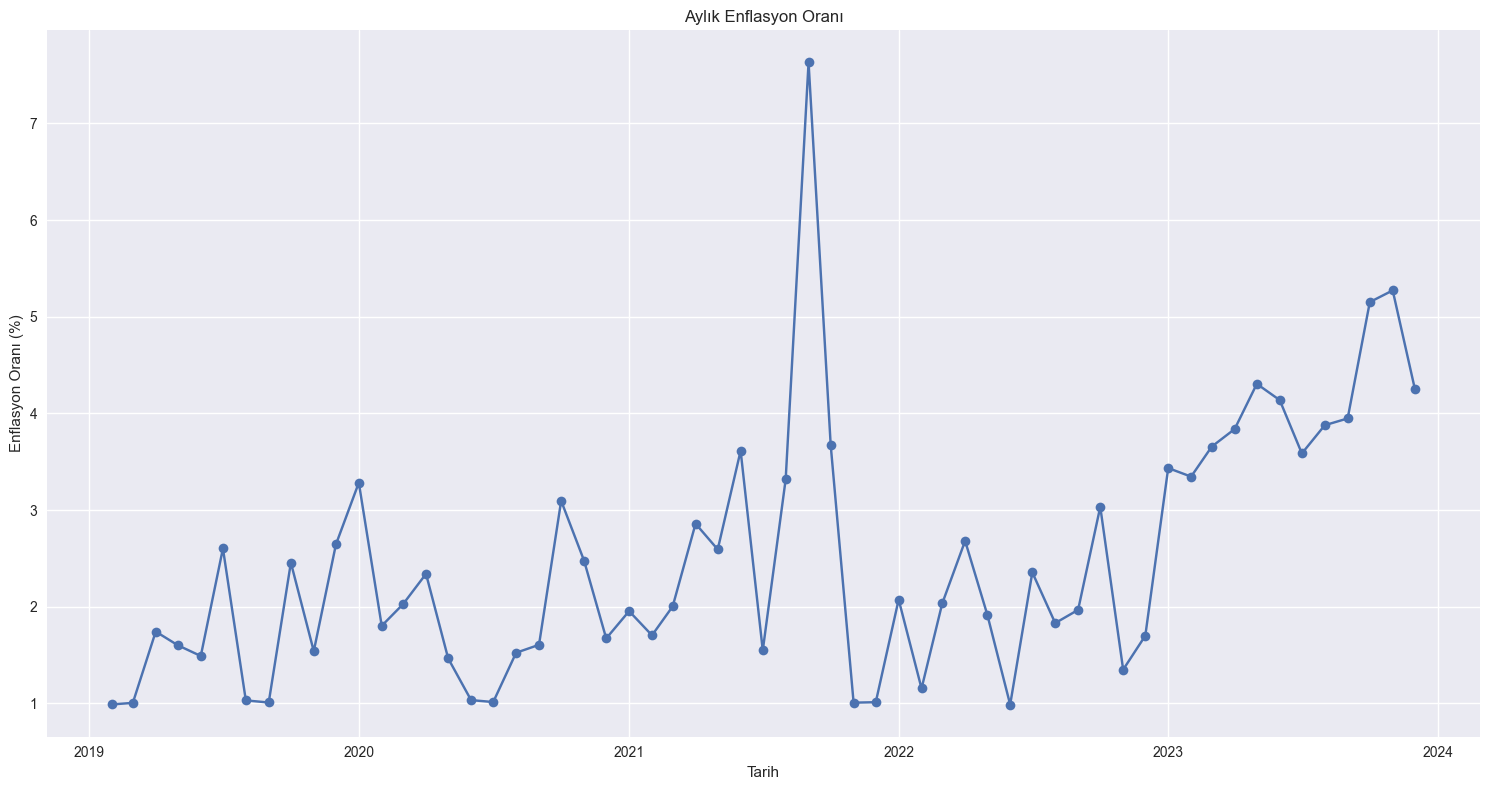

In [33]:
# Zaman içinde fiyat trendi
plt.figure(figsize=(15, 8))

# Tarihe göre gruplandırarak ortalama fiyatı hesaplama
zaman_serisi = train_data.groupby('tarih')['ürün fiyatı'].mean().reset_index()

# Zaman serisi çizimi
plt.plot(zaman_serisi['tarih'], zaman_serisi['ürün fiyatı'], marker='o', linestyle='-')
plt.title('Zaman İçinde Ortalama Fiyat Trendi')
plt.xlabel('Tarih')
plt.ylabel('Ortalama Fiyat')
plt.grid(True)
plt.tight_layout()
plt.show()

# Aylık enflasyon oranı hesaplama
zaman_serisi['aylık_enflasyon'] = zaman_serisi['ürün fiyatı'].pct_change() * 100

# Aylık enflasyon çizimi
plt.figure(figsize=(15, 8))
plt.plot(zaman_serisi['tarih'][1:], zaman_serisi['aylık_enflasyon'][1:], marker='o', linestyle='-')
plt.title('Aylık Enflasyon Oranı')
plt.xlabel('Tarih')
plt.ylabel('Enflasyon Oranı (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Tarih Bazlı Analiz

## Ay Bazlı Fiyat Analizi

Aşağıdaki grafikler, aylar bazında ortalama fiyatları ve bir önceki aya göre yüzdelik değişimleri göstermektedir. Bu analiz, yıl içindeki mevsimsel fiyat değişimlerini anlamamıza yardımcı olacaktır.

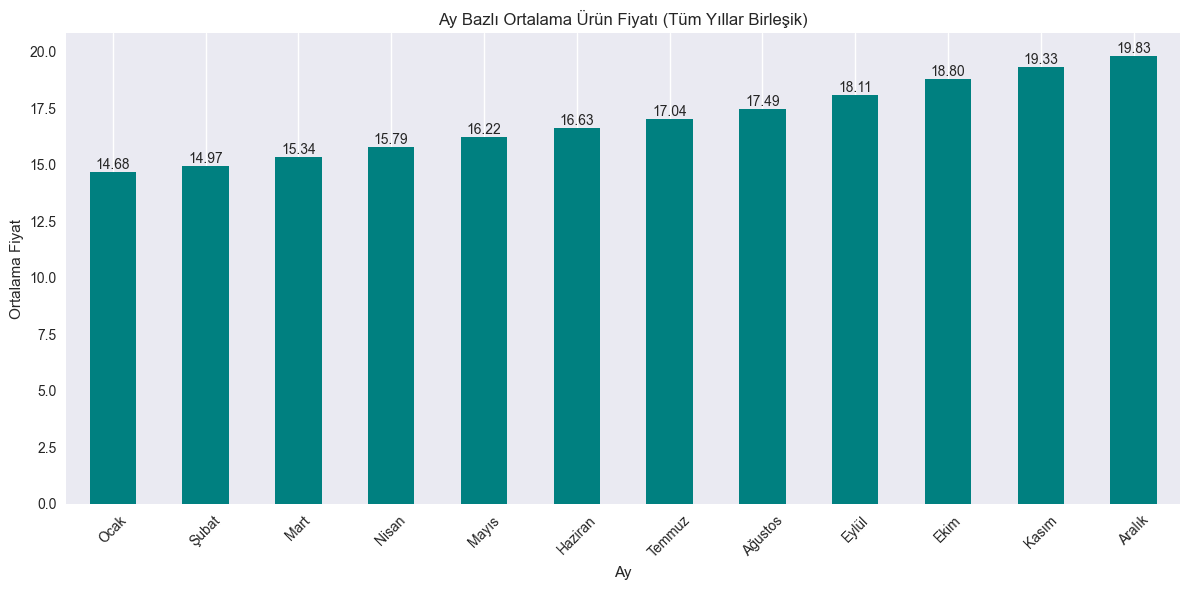

In [34]:
# Ay sütunu oluşturma
train_data['ay'] = train_data['tarih'].dt.month

# Ay bazında fiyat değişimi
ay_bazlı_ort = train_data.groupby('ay')['ürün fiyatı'].mean().round(2)

plt.figure(figsize=(12, 6))
ay_bazlı_ort.plot(kind='bar', color='teal')

# Üzerine değerleri yaz
for i, val in enumerate(ay_bazlı_ort):
    plt.text(i, val, f"{val:.2f}", ha='center', va='bottom')

plt.title('Ay Bazlı Ortalama Ürün Fiyatı (Tüm Yıllar Birleşik)')
plt.xlabel('Ay')
plt.ylabel('Ortalama Fiyat')
plt.xticks(ticks=range(12), labels=[
    'Ocak', 'Şubat', 'Mart', 'Nisan', 'Mayıs', 'Haziran',
    'Temmuz', 'Ağustos', 'Eylül', 'Ekim', 'Kasım', 'Aralık'
], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Aylara Göre Yüzdelik Artış
Bir önceki aya göre yüzdelik değişimi analiz ediyoruz.

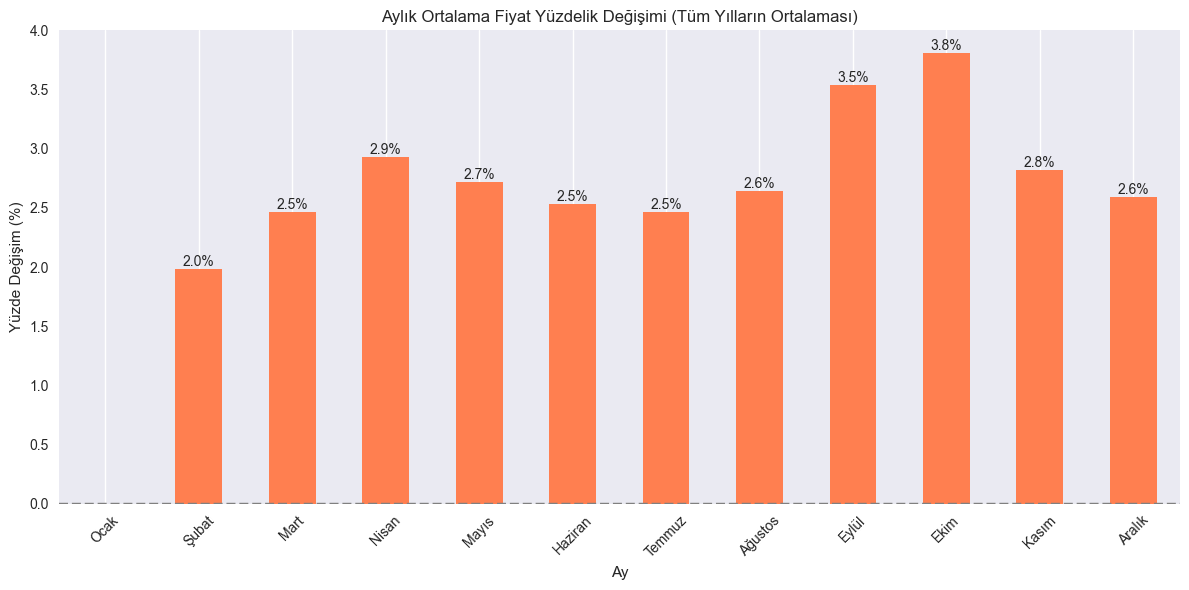

In [35]:
ay_bazlı_yüzdelik_artış = ay_bazlı_ort.pct_change() * 100
ay_bazlı_yüzdelik_artış = ay_bazlı_yüzdelik_artış.round(2)

plt.figure(figsize=(12, 6))
ay_bazlı_yüzdelik_artış.plot(kind='bar', color='coral')

# Değerleri üzerine yaz
for i, val in enumerate(ay_bazlı_yüzdelik_artış):
    if pd.notnull(val):
        plt.text(i, val, f"{val:.1f}%", ha='center', va='bottom' if val >= 0 else 'top')

plt.title('Aylık Ortalama Fiyat Yüzdelik Değişimi (Tüm Yılların Ortalaması)')
plt.xlabel('Ay')
plt.ylabel('Yüzde Değişim (%)')
plt.xticks(ticks=range(12), labels=[
    'Ocak', 'Şubat', 'Mart', 'Nisan', 'Mayıs', 'Haziran',
    'Temmuz', 'Ağustos', 'Eylül', 'Ekim', 'Kasım', 'Aralık'
], rotation=45)
plt.axhline(0, color='gray', linestyle='--')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Zaman Serisi Analizi ve SARIMA Modeli

EDA sonucunda yaptığımız çıkarımlara göre fiyatlara en çok etki eden şeyin "paranın zaman değeri" olduğunu gördük. Bunu "enflasyon" olarak isimlendirebiliriz.
Yaptığımız toplantıdan sonra bu çıkarımı kullanarak bir zaman serisi modeli ile gelecek senenin enflasyonunu kategorilerine göre tahmin etmeye çalışacağız.

Bu bölümde, ürün kategorilerine göre aylık enflasyon oranlarını hesaplayacak ve SARIMA (Seasonal AutoRegressive Integrated Moving Average) modelini kullanarak 2024 yılı için enflasyon tahminleri yapacağız. Bu tahminleri kullanarak, test veri setindeki ürünlerin 2024 yılı fiyatlarını öngöreceğiz.

## SARIMA Modeli Nedir?

SARIMA, mevsimsel etkiler içeren zaman serisi verilerini modellemek için kullanılan bir istatistiksel yöntemdir. Model, aşağıdaki bileşenlerden oluşur:

- **AR (Otoregresif)**: Serinin geçmiş değerlerine dayalı bileşen
- **I (Entegre)**: Seriyi durağanlaştırmak için fark alma işlemi
- **MA (Hareketli Ortalama)**: Geçmiş hata terimlerine dayalı bileşen
- **Mevsimsel Bileşenler**: Yıllık, aylık gibi periyodik desenleri yakalamak için

Bu projede, her ürün kategorisi için ayrı bir SARIMA modeli oluşturacak ve bu modelleri kullanarak 2024 yılı enflasyon tahminleri yapacağız.

In [16]:
# Her kategori için aylık enflasyon hesaplama fonksiyonu
def aylık_enflasyon_hesapla(data, kategori=None):
    if kategori:
        kategori_verisi = data[data['ürün kategorisi'] == kategori].copy()
    else:
        kategori_verisi = data.copy()
    
    # Aylara göre ortalama fiyatları hesaplama
    aylık_ort = kategori_verisi.groupby(pd.Grouper(key='tarih', freq='M'))['ürün fiyatı'].mean().reset_index()
    
    # Aylık enflasyon hesaplama (bir önceki aya göre yüzde değişim)
    aylık_ort['enflasyon'] = aylık_ort['ürün fiyatı'].pct_change() * 100
    
    return aylık_ort

# SARIMA modeli ile enflasyon tahmini yapma fonksiyonu
def enflasyon_tahmini(enflasyon_verisi, dönem=12):
    # NaN değerleri kaldırma
    y = enflasyon_verisi['enflasyon'].dropna()

    # SARIMA modeli
    model = SARIMAX(
        y,
        order=(2, 1, 0),
        seasonal_order=(0, 0, 0, 12),  # Yıllık mevsimsellik varsayımı
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)

    # Gelecek dönem için tahmin
    tahmin = model_fit.forecast(steps=dönem)
    return tahmin

# Bir ürünün en son bilinen fiyatını bulma fonksiyonu
def son_fiyat_bul(data, ürün, market, şehir):
    # Belirli ürün, market ve şehir için en son fiyatı bulma
    filtrelenmiş = data[(data['ürün'] == ürün) & 
                    (data['market'] == market) & 
                    (data['şehir'] == şehir)]
    if filtrelenmiş.empty:
        # Eğer tam eşleşme yoksa, sadece ürün bazında arama
        filtrelenmiş = data[data['ürün'] == ürün]
    
    if filtrelenmiş.empty:
        return None
    
    return filtrelenmiş.sort_values('tarih', ascending=False).iloc[0]['ürün fiyatı']

# İki tarih arasındaki ay farkını hesaplama fonksiyonu
def ay_farkı_hesapla(tarih1, tarih2):
    tarih1 = pd.to_datetime(tarih1)
    tarih2 = pd.to_datetime(tarih2)
    return ((tarih1.year - tarih2.year) * 12 + tarih1.month - tarih2.month)

# 2024 yılı fiyatlarını tahmin etme fonksiyonu
def fiyat_tahmini_2024(train_data, test_data):
    tahminler = []
    
    # Her ürün kategorisi için
    kategoriler = train_data['ürün kategorisi'].unique()
    for kategori in kategoriler:
        # Kategori için enflasyon hesaplama
        enflasyon_verisi = aylık_enflasyon_hesapla(train_data, kategori)
        
        # 2024 için enflasyon tahminleri
        enflasyon_tahmini_sonuç = enflasyon_tahmini(enflasyon_verisi)
        
        # Bu kategorideki ürünleri test setinden alma
        kategori_test = test_data[test_data['ürün kategorisi'] == kategori]
        
        # Her test ürünü için
        for idx, satır in kategori_test.iterrows():
            # Test ürününün en son bilinen fiyatı (2023 Aralık)
            son_fiyat = son_fiyat_bul(train_data, satır['ürün'], satır['market'], satır['şehir'])
            
            # Tarih farkını hesaplama (2024 tarihi - 2023 Aralık)
            ay_farkı = ay_farkı_hesapla(satır['tarih'], '2023-12-01')
            
            # Enflasyon tahminlerini kullanarak yeni fiyat hesaplama
            kümülatif_enflasyon = np.sum(enflasyon_tahmini_sonuç[:ay_farkı]) / 100
            tahmin_fiyat = son_fiyat * (1 + kümülatif_enflasyon)
            
            tahminler.append({
                'id': satır['id'],
                'ürün fiyatı': tahmin_fiyat
            })
    
    return pd.DataFrame(tahminler)

## Model Uygulaması ve Tahminler

Şimdi, oluşturduğumuz fonksiyonları kullanarak 2024 yılı için fiyat tahminleri yapacağız. Her ürün kategorisi için ayrı bir SARIMA modeli eğitilecek ve bu modeller kullanılarak test veri setindeki ürünlerin 2024 yılı fiyatları tahmin edilecektir.

In [ ]:
# Tahminleri oluşturma
tahminler = fiyat_tahmini_2024(train_data, test_data)

c:\Users\SONAT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\SONAT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\SONAT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\SONAT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.p

,id,ürün fiyatı
0,0,148.019297
1,1,47.112260
2,2,53.700656
3,79,148.019297
4,80,47.112260


In [24]:
tahminler = tahminler.sort_values(by="id")
tahminler.head()

,id,ürün fiyatı
0,0,148.019297
1,1,47.112260
2,2,53.700656
1728,3,29.934875
1729,4,52.858824


In [25]:
# Tahminleri test verisiyle birleştirme
birleştirilmiş_df = pd.merge(test_data, tahminler, on='id', how='left')

# Birleştirilmiş veri setinin ilk birkaç satırını görüntüleme
birleştirilmiş_df.head(50)

,id,tarih,ürün,ürün besin değeri,ürün kategorisi,ürün üretim yeri,market,şehir,ürün fiyatı
0,0,2024-01-01,kıyma,120,et,Yurt içi,K,S,148.019297
1,1,2024-01-01,tavuk,103,et,Yurt içi,K,S,47.112260
2,2,2024-01-01,hindi,160,et,Yurt içi,K,S,53.700656
3,3,2024-01-01,Bakla-kuru,354,sebze ve bakliyat,Yurt içi,K,S,29.934875
4,4,2024-01-01,Bakla-taze,72,sebze ve bakliyat,Yurt içi,K,S,52.858824
5,5,2024-01-01,Bamya,42,sebze ve bakliyat,Yurt içi,K,S,21.074570
6,6,2024-01-01,Barbunya-kuru,346,sebze ve bakliyat,Yurt içi,K,S,26.758539
7,7,2024-01-01,Bezelye-taze,47,sebze ve bakliyat,Yurt içi,K,S,48.867507
8,8,2024-01-01,Biber-yeşil,25,sebze ve bakliyat,Yurt içi,K,S,47.958490
9,9,2024-01-01,Brüksel laha.,47,sebze ve bakliyat,Yurt içi,K,S,110.137352


## Tahmin Sonuçlarının Görselleştirilmesi

Tahminler ile geçmiş verileri birleştirerek oluşturulan trendi aşağıdaki grafik ile görselleştiriyoruz. Bu görselleştirme, elde ettiğimiz tahminin trendini anlamamıza yardımcı olacaktır.

In [31]:
#birleştirme 
birleştirilmiş_df_withoutID = birleştirilmiş_df.drop(columns=['id'])

all_years = pd.concat([train_data, birleştirilmiş_df_withoutID], ignore_index=True)

all_years['tarih'] = pd.to_datetime(all_years['tarih']) 
all_years['year'] = all_years['tarih'].dt.year

avg_prices_by_year = all_years.groupby('year')['ürün fiyatı'].mean().reset_index()

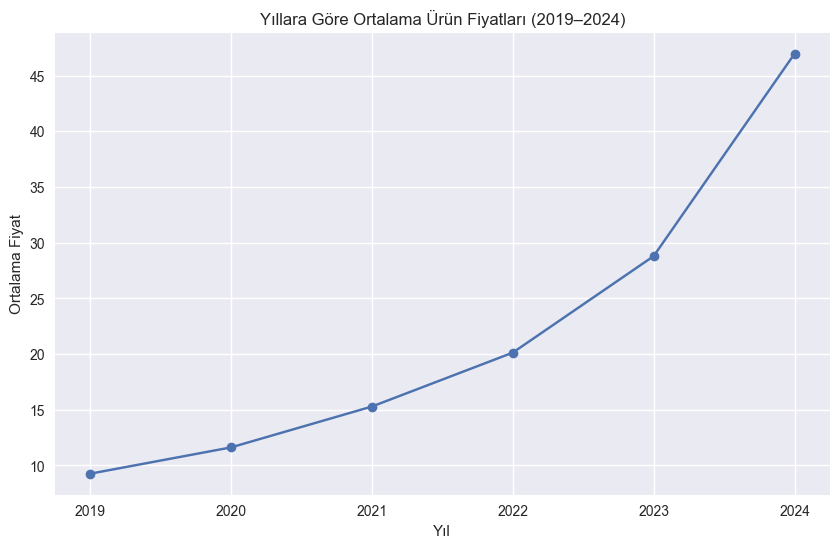

In [32]:
plt.figure(figsize=(10,6))
plt.plot(avg_prices_by_year['year'], avg_prices_by_year['ürün fiyatı'], marker='o', linestyle='-')
plt.title("Yıllara Göre Ortalama Ürün Fiyatları (2019–2024)")
plt.xlabel("Yıl")
plt.ylabel("Ortalama Fiyat")
plt.grid(True)
plt.xticks(avg_prices_by_year['year'])  # Tüm yılları eksen üzerinde göster
plt.show()

# Sonuçlar ve Değerlendirme

Bu bölümde, analizlerimizin sonuçlarını özetleyecek ve tahminlerimizi değerlendireceğiz.

In [20]:
# Gönderim dosyasını hazırlama
gönderim = tahminler[['id', 'ürün fiyatı']]
gönderim.to_csv('submission.csv', index=False)

print("Gönderim dosyası", len(gönderim), "tahmin ile oluşturuldu.")


Gönderim dosyası 45504 tahmin ile oluşturuldu.


In [21]:
# Tahminlerin özet istatistikleri
print("\nTahminlerin Özet İstatistikleri:")
print(tahminler['ürün fiyatı'].describe())


Tahminlerin Özet İstatistikleri:
count    45504.000000
mean        46.962776
std         32.675441
min          2.996629
25%         23.816394
50%         37.470451
75%         64.707649
max        239.549148
Name: ürün fiyatı, dtype: float64


In [22]:
# Ortalama tahmini enflasyon oranını hesaplama
ilk_ay = birleştirilmiş_df[birleştirilmiş_df['tarih'].dt.month == 1]['ürün fiyatı'].mean()
son_ay = birleştirilmiş_df[birleştirilmiş_df['tarih'].dt.month == 12]['ürün fiyatı'].mean()
yıllık_enflasyon = ((son_ay / ilk_ay) - 1) * 100

print(f"\n2024 Yılı İçin Tahmini Yıllık Enflasyon Oranı: {yıllık_enflasyon:.2f}%")


2024 Yılı İçin Tahmini Yıllık Enflasyon Oranı: 49.27%


## Sonuç ve Değerlendirme

Bu projede, ürün fiyatlarının zaman içindeki değişimini analiz ederek 2024 yılı için fiyat tahminleri yaptık.

### Temel Bulgular:
1. Veri setimiz, farklı fiyat trendlerine sahip çeşitli ürün kategorileri içermektedir
2. Market, şehir ve ürünün üretim yeri ile ürün fiyatı arasında bir anlamlı ilişki bulunamamıştır

### Metodoloji:
- Veri karakteristiklerini anlamak için keşifsel veri analizi kullandık
- Her ürün kategorisi için enflasyon oranlarını tahmin etmek üzere SARIMA modeli oluşturduk
- Bu enflasyon tahminlerini kullanarak 2024 yılı fiyatlarını öngördük

### Kısıtlamalar:
- Model, geçmiş trendlerin gelecekte de devam edeceğini varsaymaktadır

### Sonraki Adımlar:
- Karşılaştırma için farklı zaman serisi modelleri denemek
- Hyper Parameter Optimization ile model parametrelerini optimize etmek
- Modelin performansını daha detaylı analiz etmek
- ML algoritması kullanarak enflasyon bilgisini feature olarak kullanarak tahminlerimizi geliştirmek

# Yarışma Sonuçları

Bu proje, "Takım 7" ekibi tarafından YZTA Datathon yarışması için geliştirilmiştir. Ekip olarak aşağıdaki sonuçları elde ettik:

- **Ekip Adı**: Takım 7
- **Public Skor**: 4.79
- **Private Skor**: 4.93
- **Genel Sıralama**: 12. sıra

Bu sonuçlar, ekibimizin geliştirdiği SARIMA modelinin enflasyon tahminini çerçevesinde fiyatları tahmin ederken makul bir performans gösterdiğini ve yaklaşık 130 takım arasından 12. olarak rekabetçi bir çözüm sunduğunu kanıtlamaktadır. Daha yüksek sıralama elde etmek için gelecek çalışmalarda, daha karmaşık zaman serisi modelleri (örneğin, Prophet, LSTM) denenebilir veya makine öğrenimi algoritması ile fiyat tahminlerini daha da geliştirilebilir.

Sonuç olarak, Takım 7 ekibi olarak geliştirdiğimiz bu model, elimizdeki veri setine uygun olarak enflasyon bazlı fiyat tahmininde başarılı bir yaklaşım sunmakta ve gelecekteki fiyat tahminleri için sağlam bir temel oluşturmaktadır.

## Ekip Üyeleri

| İsim | E-posta |
|------|-----|
| Sonat Saygın İpek | sonatsayginipek@gmail.com | 
| Ahmet Melih Çalış | a.melihcalis@gmail.com |
| Zehra Yavaşoğlu | zehrayavasoglu19@gmail.com |
| İhsan Tutak | ihsan.tutak@gmail.com |
| Melisa Bayramoğlu | melisa.bayramoglu03@gmail.com |